# **AA1 Project** 

## Modeling delays in the air

In order to predict whether a flight is likely to be delayed or not, create a ML model that will make predictions with that aim. 

First of all. Let's observe our data set and some first insights. 

In [95]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

In [96]:
airports = pd.read_csv('airports.csv')

In [97]:
flights = pd.read_csv('flights.csv')
flights = flights.sample(frac=0.01, random_state=42)

/var/folders/6p/292cfjv12xd9n9pzpglsj3w00000gn/T/ipykernel_21080/3164755004.py:1: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  flights = pd.read_csv('flights.csv')


As we can se with the `describe` method, we can observe the range where each feature takes values at more or less. It is also interesting to observe the histograms of the different columns to see how each feature is distributed more or less, to get an intuition of our data. 

In [98]:
count = 0
for airport in flights["ORIGIN_AIRPORT"]:
    if str(airport).isnumeric():
      count += 1
print(count)

4827


In [99]:
flights.describe()
airports.describe()

,LATITUDE,LONGITUDE
count,319.000000,319.000000
mean,38.981244,-98.378964
std,8.616736,21.523492
min,13.483450,-176.646030
25%,33.652040,-110.839385
50%,39.297610,-93.403070
75%,43.154675,-82.722995
max,71.285450,-64.798560


array([[<AxesSubplot: title={'center': 'YEAR'}>,
        <AxesSubplot: title={'center': 'MONTH'}>,
        <AxesSubplot: title={'center': 'DAY'}>,
        <AxesSubplot: title={'center': 'DAY_OF_WEEK'}>,
        <AxesSubplot: title={'center': 'FLIGHT_NUMBER'}>],
       [<AxesSubplot: title={'center': 'SCHEDULED_DEPARTURE'}>,
        <AxesSubplot: title={'center': 'DEPARTURE_TIME'}>,
        <AxesSubplot: title={'center': 'DEPARTURE_DELAY'}>,
        <AxesSubplot: title={'center': 'TAXI_OUT'}>,
        <AxesSubplot: title={'center': 'WHEELS_OFF'}>],
       [<AxesSubplot: title={'center': 'SCHEDULED_TIME'}>,
        <AxesSubplot: title={'center': 'ELAPSED_TIME'}>,
        <AxesSubplot: title={'center': 'AIR_TIME'}>,
        <AxesSubplot: title={'center': 'DISTANCE'}>,
        <AxesSubplot: title={'center': 'WHEELS_ON'}>],
       [<AxesSubplot: title={'center': 'TAXI_IN'}>,
        <AxesSubplot: title={'center': 'SCHEDULED_ARRIVAL'}>,
        <AxesSubplot: title={'center': 'ARRIVAL_TIME'}>

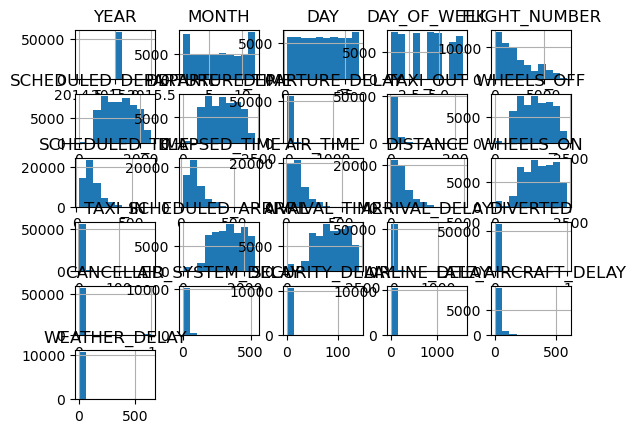

In [100]:
flights.hist()

## 1. Data cleaning
### Nextly we will portray the schedule that we are going to follow. 
1. Check for duplicates: Check for and remove any duplicate rows in your dataset.

2. Handle missing data: Identify any missing data and decide how to handle it. You can either remove the rows or fill in the missing data.

3. Check for inconsistent data: Check for any inconsistent or erroneous data, such as values that are out of range or inconsistent with other data in the same row.

4. Handle categorical data: If you have categorical data, decide how to handle it. One common approach is to use one-hot encoding.

5. Normalize data: Normalize your data so that the features have similar ranges. This will prevent features with large ranges from dominating the model.

6. Feature selection: Select the most relevant features for your model. You can use various techniques such as correlation analysis or principal component analysis (PCA).

7. Train-test split: Finally, split your data into training and testing sets to evaluate the performance of your machine learning model.

###1.1 Check for duplicates
We firstly see that there are no duplicate samples with the following piece of code.


In [101]:
# Check for duplicates
duplicates = flights.duplicated()

# Print the duplicate rows
len(flights[duplicates])

0

###1.2 Handle missing data
In this section we have a bunch of different possibilities in order to approach the problem of missing data. 
1. Remove missing data: if the quantity of missing data is not that significative, maybe it is a good option to consider removing all those samples that contain `NaN` values since the subset of samples that is going to be deleted may not be significant while training the model. 



In [102]:
# Count the number of NaN values in each column
nan_counts = flights.isna().sum()
# Print the results
print(nan_counts)

YEAR                       0
MONTH                      0
DAY                        0
DAY_OF_WEEK                0
AIRLINE                    0
FLIGHT_NUMBER              0
TAIL_NUMBER              145
ORIGIN_AIRPORT             0
DESTINATION_AIRPORT        0
SCHEDULED_DEPARTURE        0
DEPARTURE_TIME           870
DEPARTURE_DELAY          870
TAXI_OUT                 906
WHEELS_OFF               906
SCHEDULED_TIME             0
ELAPSED_TIME            1052
AIR_TIME                1052
DISTANCE                   0
WHEELS_ON                941
TAXI_IN                  941
SCHEDULED_ARRIVAL          0
ARRIVAL_TIME             941
ARRIVAL_DELAY           1052
DIVERTED                   0
CANCELLED                  0
CANCELLATION_REASON    57275
AIR_SYSTEM_DELAY       47521
SECURITY_DELAY         47521
AIRLINE_DELAY          47521
LATE_AIRCRAFT_DELAY    47521
WEATHER_DELAY          47521
dtype: int64


From the previous output we see that the last 6 features are almost useless since the majority of the samples do not have any information of those, therefore we are going to `drop`. A part from that, we also need to delete columns that regard information that is not going to be available (a posteriori information from the flight) such as information of the time elapsed during time

In [103]:
cols_of_interest = ['ARRIVAL_DELAY','MONTH', 'DAY' ,'DAY_OF_WEEK', 'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_ARRIVAL', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME', 'DISTANCE']
flights = flights[cols_of_interest]

In [104]:
flights.describe()

,ARRIVAL_DELAY,MONTH,DAY,DAY_OF_WEEK,SCHEDULED_ARRIVAL,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE
count,57139.000000,58191.000000,58191.000000,58191.000000,58191.000000,57321.000000,57321.000000,57285.000000,57285.000000,58191.000000,58191.000000
mean,4.247099,6.527831,15.682906,3.906309,1491.585280,1331.780744,9.211493,15.991307,1354.400524,142.050162,825.198209
std,38.170335,3.405551,8.788558,1.983664,506.735443,496.183602,35.887713,8.805748,497.519944,75.544876,609.862887
min,-62.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-36.000000,1.000000,1.000000,20.000000,31.000000
25%,-13.000000,4.000000,8.000000,2.000000,1109.000000,920.000000,-5.000000,11.000000,934.000000,86.000000,374.000000
50%,-5.000000,7.000000,16.000000,4.000000,1517.000000,1325.000000,-2.000000,14.000000,1338.000000,123.000000,647.000000
75%,8.000000,9.000000,23.000000,6.000000,1915.000000,1737.000000,7.000000,19.000000,1752.000000,174.000000,1067.000000
max,1557.000000,12.000000,31.000000,7.000000,2359.000000,2400.000000,1576.000000,225.000000,2400.000000,680.000000,4983.000000


Once we've deleted those columns we can say that **maybe** and only **maybe** taking into account that we have more than 5M samples, deleting the other samples that contain at least one `NaN` value, may be reasonable. 

**CHECK WHETHER THIS IS REASONABLE**

In [105]:
l_bef = len(flights)
flights = flights.dropna(how='any')
l_aft = len(flights)
print(l_bef, l_aft)

58191 57139


We pass from $5819079$ to $5714008$ samples. In other words, we keep the $98.2\%$ of the samples, so it may be a good option to work with these new subset of samples that still contain a vast quantity of information.   

### 1.3 Check for inconsistent data
In order to do so, we firstly observe an overview of our data. 


In [106]:
flights.describe()


,ARRIVAL_DELAY,MONTH,DAY,DAY_OF_WEEK,SCHEDULED_ARRIVAL,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE
count,57139.000000,57139.000000,57139.000000,57139.000000,57139.000000,57139.000000,57139.000000,57139.000000,57139.000000,57139.000000,57139.000000
mean,4.247099,6.552582,15.677086,3.912144,1490.692049,1331.771995,9.150283,15.988939,1354.442185,142.286197,827.655069
std,38.170335,3.396218,8.779017,1.980102,506.920966,496.271059,35.759315,8.802249,497.601001,75.683546,611.087524
min,-62.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-36.000000,1.000000,1.000000,20.000000,31.000000
25%,-13.000000,4.000000,8.000000,2.000000,1109.000000,919.000000,-5.000000,11.000000,934.000000,86.000000,376.000000
50%,-5.000000,7.000000,16.000000,4.000000,1515.000000,1325.000000,-2.000000,14.000000,1338.000000,123.000000,650.000000
75%,8.000000,9.000000,23.000000,6.000000,1915.000000,1737.000000,7.000000,19.000000,1752.000000,174.000000,1068.000000
max,1557.000000,12.000000,31.000000,7.000000,2359.000000,2400.000000,1576.000000,225.000000,2400.000000,680.000000,4983.000000


In [107]:
print(flights["DESTINATION_AIRPORT"].unique())

['DTW' 'SEA' 'DAL' 'HNL' 'ATL' 'TPA' 'PHX' 'LAX' 11292 'BWI' 'SJU' 'SMF'
 'BNA' 'CLT' 'CAE' 'MSP' 'DFW' 'SAN' 'OGG' 'OAK' 14107 'DCA' 'BOS' 'HRL'
 'MCI' 'SNA' 'ORD' 'MIA' 'RNO' 12451 'SFO' 'SAT' 'IAH' 'SLC' 'LAS' 'DEN'
 'PIT' 'ACV' 'DRO' 'GSP' 'RSW' 'ITO' 12266 'LSE' 'OKC' 'DAY' 'EWR' 10299
 'PHL' 'HOU' 11298 'MFE' 'FLL' 'MSY' 'IND' 'BZN' 'PSP' 'ASE' 'MEM' 'RDU'
 'SBA' 15016 'SJC' 11066 'JAC' 'MCO' 'ROC' 11697 'BOI' 'CLE' 13830 10257
 14908 'SDF' 12278 'MKE' 'JFK' 12889 10397 'RDM' 13851 'BRW' 'ALB' 'OMA'
 'CRP' 'RIC' 'DHN' 11618 'BUR' 'CVG' 'MDW' 14893 'JAX' 13485 'ABQ' 12402
 'CMH' 12264 10721 'PVD' 11433 'KTN' 10154 'LGA' 'PDX' 'LRD' 'SYR' 'PBI'
 'ANC' 'BUF' 'RST' 'TUL' 'TUS' 'STL' 'TLH' 'BDL' 'AUS' 'MSN' 11278 13204
 14771 'CHS' '13232' 'DSM' '12478' 14869 'AMA' 'LGB' 'GRR' 'IAD' 10874
 'ONT' 'LIH' 'PIB' 15370 10980 13303 'GSO' 'MYR' 12478 11057 'BIS' 13930
 'CDV' 14679 10713 'MOB' 14576 'KOA' 'TRI' 'CHO' 14843 'LEX' 11447 'MGM'
 15919 14057 'ELP' 'IDA' 'MVY' 'EWN' 13487 10140 'COS

In [108]:

for index, row in flights.iterrows():
  if flights.loc[index]["WHEELS_OFF"] == 2400:
    flights.loc[index, "WHEELS_OFF"] = 2359
  if flights.loc[index]["DEPARTURE_TIME"] == 2400:
    flights.loc[index, "DEPARTURE_TIME"] = 2359

flights.describe()

,ARRIVAL_DELAY,MONTH,DAY,DAY_OF_WEEK,SCHEDULED_ARRIVAL,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE
count,57139.000000,57139.000000,57139.000000,57139.000000,57139.000000,57139.000000,57139.000000,57139.000000,57139.000000,57139.000000,57139.000000
mean,4.247099,6.552582,15.677086,3.912144,1490.692049,1331.769124,9.150283,15.988939,1354.438597,142.286197,827.655069
std,38.170335,3.396218,8.779017,1.980102,506.920966,496.264999,35.759315,8.802249,497.593610,75.683546,611.087524
min,-62.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-36.000000,1.000000,1.000000,20.000000,31.000000
25%,-13.000000,4.000000,8.000000,2.000000,1109.000000,919.000000,-5.000000,11.000000,934.000000,86.000000,376.000000
50%,-5.000000,7.000000,16.000000,4.000000,1515.000000,1325.000000,-2.000000,14.000000,1338.000000,123.000000,650.000000
75%,8.000000,9.000000,23.000000,6.000000,1915.000000,1737.000000,7.000000,19.000000,1752.000000,174.000000,1068.000000
max,1557.000000,12.000000,31.000000,7.000000,2359.000000,2359.000000,1576.000000,225.000000,2359.000000,680.000000,4983.000000


As we can infer from the output of the `decribe()` method, there are no values that are out of range or are non-sense in comparison with other values of the same column. 

In [109]:
# Delete all of the rows that contain integer values
flights = flights[~flights['ORIGIN_AIRPORT'].apply(lambda x: isinstance(x, int))]
flights = flights[~flights['DESTINATION_AIRPORT'].apply(lambda x: isinstance(x, int))]


In [110]:
flights = flights[~flights['ORIGIN_AIRPORT'].apply(lambda x: str(x).isnumeric())]
flights = flights[~flights['DESTINATION_AIRPORT'].apply(lambda x: str(x).isnumeric())]

### 1.4 Handle categorical data


In [111]:
#Check nature of the columns 
for col in flights.columns:
  print(col, flights[col].dtype)

ARRIVAL_DELAY float64
MONTH int64
DAY int64
DAY_OF_WEEK int64
AIRLINE object
ORIGIN_AIRPORT object
DESTINATION_AIRPORT object
SCHEDULED_ARRIVAL int64
DEPARTURE_TIME float64
DEPARTURE_DELAY float64
TAXI_OUT float64
WHEELS_OFF float64
SCHEDULED_TIME float64
DISTANCE int64


The next thing we want to do after observing the types of every feature is to transform some variables to categorical. To start with, we are going to partition 4 airport areas for the US, so that data is more manageable

In [112]:
# MONTH treatment

flights['Q_YEAR'] = flights['MONTH'].apply(lambda x: (x-1)//4 + 1)

In [113]:
# DELAY TREATMENT
flights['DELAYED'] = flights['ARRIVAL_DELAY'].apply(lambda x: 1 if x > 0 else 0)

We observe a huge amount of features which may overfit the model in case of using them all. Therefore we will try to choose an optimal subset of explanatory variables that are going to be able to give our model the enough information in order to do good predictions. 

**Observation: We cannot follow like this since we need to consider some categorical variables. REMEMBER to one_shot_encode them before going on**

In [114]:
# DAY treatment 

flights['FORTNIGHT'] = pd.cut(flights['DAY'], bins=[0, 15, 31], labels=[1, 2], include_lowest=True)


In [115]:
# DAY_OF_WEEK 1 is in-week days, 2 is weekend

flights['WEEK_INFO'] = pd.cut(flights['DAY_OF_WEEK'], bins=[1, 5, 7], labels=[1, 2], include_lowest=True)


In [116]:
# AIRLINE

# define the airline categories based on domain knowledge RECordar mirar criteri de cost d'aerolinies !!!!!!!
major_airlines = ['DL', 'AA', 'UA', 'US']
low_cost_airlines = ['WN', 'NK', 'F9', 'B6', 'VX']
regional_airlines = ['EV', 'OO', 'MQ', 'AS', 'HA']

# create a new column with the airline category
flights['AC'] = 'Other'
flights.loc[flights['AIRLINE'].isin(major_airlines), 'AC'] = 'Major'
flights.loc[flights['AIRLINE'].isin(low_cost_airlines), 'AC'] = 'Low-Cost'
flights.loc[flights['AIRLINE'].isin(regional_airlines), 'AC'] = 'Regional'

In [117]:
airports = airports.set_index('IATA_CODE')


In [118]:
# adding longitude and latitude values for origin airport 
flights['LONGITUDE_O'] = 0.0
flights['LATITUDE_O'] = 0.0

for index,row in flights.iterrows():
  a_act = flights.loc[index]["ORIGIN_AIRPORT"]
  long = airports.loc[a_act]["LONGITUDE"]
  lat = airports.loc[a_act]["LATITUDE"]
  flights.loc[index,"LONGITUDE_O"] = long
  flights.loc[index,"LATITUDE_O"] = lat 

In [119]:
# we observe some nans are generated and we remove them 
coso = flights["LONGITUDE_O"].isna() == False
count_true = sum(coso)
print(count_true)
print(len(flights["LONGITUDE_O"]))

flights = flights.dropna(how='any')


52307
52350


In [120]:
flights['GR_O'] = ''
flights.loc[(flights['LONGITUDE_O'] >= -100) & (flights['LATITUDE_O'] >= 37), 'GR_O'] = 'UPPER_RIGHT'
flights.loc[(flights['LONGITUDE_O'] < -100) & (flights['LATITUDE_O'] >= 37), 'GR_O'] = 'UPPER_LEFT'
flights.loc[(flights['LONGITUDE_O'] >= -100) & (flights['LATITUDE_O'] < 37), 'GR_O'] = 'BOTTOM_RIGHT'
flights.loc[(flights['LONGITUDE_O'] < -100) & (flights['LATITUDE_O'] < 37), 'GR_O'] = 'BOTTOM_LEFT'


In [121]:
flights["GR_O"].unique()

array(['UPPER_RIGHT', 'BOTTOM_LEFT', 'UPPER_LEFT', 'BOTTOM_RIGHT'],
      dtype=object)

In [122]:
# adding longitude and latitude values for destination airport 
flights['LONGITUDE_D'] = 0.0
flights['LATITUDE_D'] = 0.0

for index,row in flights.iterrows():
  a_act = flights.loc[index]["DESTINATION_AIRPORT"]
  long = airports.loc[a_act]["LONGITUDE"]
  lat = airports.loc[a_act]["LATITUDE"]
  flights.loc[index,"LONGITUDE_D"] = long
  flights.loc[index,"LATITUDE_D"] = lat 
  


In [123]:
flights['GR_D'] = ''
flights.loc[(flights['LONGITUDE_D'] >= -100) & (flights['LATITUDE_D'] >= 37), 'GR_D'] = 'UPPER_RIGHT'
flights.loc[(flights['LONGITUDE_D'] < -100) & (flights['LATITUDE_D'] >= 37), 'GR_D'] = 'UPPER_LEFT'
flights.loc[(flights['LONGITUDE_D'] >= -100) & (flights['LATITUDE_D'] < 37), 'GR_D'] = 'BOTTOM_RIGHT'
flights.loc[(flights['LONGITUDE_D'] < -100) & (flights['LATITUDE_D'] < 37), 'GR_D'] = 'BOTTOM_LEFT'

In [124]:
# we observe some nans are generated and we remove them 
coso = flights["LONGITUDE_D"].isna() == False
count_true = sum(coso)
print(count_true)
print(len(flights["LONGITUDE_D"]))

flights = flights.dropna(how='any')

52264
52307


In [125]:
flights["GR_D"].unique()

array(['UPPER_RIGHT', 'UPPER_LEFT', 'BOTTOM_RIGHT', 'BOTTOM_LEFT'],
      dtype=object)

In [ ]:
import gmplot

# Initialize the map with the first airport as the center point
gmap = gmplot.GoogleMapPlotter(flights.iloc[0]['LATITUDE_O'], flights.iloc[0]['LONGITUDE_O'], zoom=3)

# Define the color mapping for different values of GR_D
color_map = {
    'UPPER_RIGHT': 'red',
    'UPPER_LEFT': 'green',
    'BOTTOM_RIGHT': 'blue',
    'BOTTOM_LEFT': 'purple'
}

# Plot each airport with its corresponding color
for i, row in flights.iterrows():
    color = color_map.get(row['GR_D'], 'gray')
    gmap.marker(row['LATITUDE_O'], row['LONGITUDE_O'], color=color)

# Draw the map and save it to an HTML file
gmap.draw('airports_map.html')


In [ ]:

# Define a function to classify the time segment based on the input time
def classify_time(time):
    sunrise = 600.0   # Define the time of sunrise as 6:00 am (in decimal format)
    sunset = 1800.0   # Define the time of sunset as 6:00 pm (in decimal format)
    
    if time >= sunrise and time < sunset:
        return 'Daytime'
    else:
        return 'Nighttime'
    

In [ ]:
# Change formatting of SCHEDULED_ARRIVAL and DEPARTURE_TIME
flights['ArrivalDayNight'] = flights['SCHEDULED_ARRIVAL'].apply(classify_time)
flights['DepartureDayNight'] = flights['DEPARTURE_TIME'].apply(classify_time)

In [ ]:
flights.describe()
flights.columns

In [ ]:
flights = flights[['DELAYED','DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME',
       'DISTANCE', 'Q_YEAR', 'FORTNIGHT', 'WEEK_INFO', 'AC', 'GR_O',
       'GR_D', 'ArrivalDayNight', 'DepartureDayNight']]

In [ ]:
flights.columns

In [ ]:
# Declare which variables are categorical and which ones are continuous. 

continuous = ['DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME',
       'DISTANCE']

flights[continuous].hist()


               

In [ ]:
len(flights)

In [ ]:

def remove_outliers_zscore(data_series, threshold=3):
    """
    Remove outliers from a pandas Series using the Z-score method.
    :param data_series: a pandas Series containing the data
    :param threshold: the number of standard deviations from the mean at which to consider a data point an outlier
    :return: a new pandas Series with the outliers removed
    """
    z_scores = np.abs((data_series - data_series.mean()) / data_series.std())
    return data_series[z_scores <= threshold]


In [ ]:
# We observe that no outliers are removed. 
flights_cont = remove_outliers_zscore(flights[continuous])
len(flights_cont)

In [ ]:
# we normalize continuous variables
from sklearn.preprocessing import QuantileTransformer

# Initialize transformer with number of quantiles and output distribution
transformer = QuantileTransformer(n_quantiles=100, output_distribution='normal')

# Apply transformation to continuous columns
for col in continuous:
    flights[col] = transformer.fit_transform(flights[col].values.reshape(-1, 1))

In [ ]:
flights[continuous].hist()

In [ ]:
# one hot encoding for categorical variables
categorical = ['DELAYED','Q_YEAR', 'FORTNIGHT', 'WEEK_INFO', 'AC', 'GR_O',
       'GR_D', 'ArrivalDayNight', 'DepartureDayNight']

flights_enc = pd.get_dummies(flights, columns=categorical)

In [ ]:
flights_enc


In [94]:
from sklearn.model_selection import train_test_split

# Split data into features (X) and target variable (y)
y = flights_enc['DELAYED']
X = flights_enc.drop('DELAYED', axis=1)



# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



KeyError: 'DELAYED'

In [207]:
from sklearn.linear_model import LinearRegression

# Create a linear regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

LinearRegression()

In [208]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the performance of the model on the test set
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print('MSE:', mse)


MSE: 819.2303548659775
